In [2]:
import pandas as pd
import os

# Load in the images

In [33]:
bob_directory = 'data/images/all_images/bob/'
bob_imgs = os.listdir(bob_directory)

not_bob_directory = 'data/images/all_images/not_bob/'
not_bob_imgs = os.listdir(not_bob_directory)

In [73]:
def create_title(x):
    try:
        return x.split('_')[0]
    except:
        return x
    
def create_df(images, directory, bob=False):
    df = pd.DataFrame(images)
    df.columns = ['filename']
    df['title'] = df['filename'].apply(create_title)
    df['filetype'] = df['filename'].apply(lambda x: x.split('.')[-1])
    df['fullpath'] = directory + df['filename']
    if bob:
        df['target'] = 'bob'
    else:
        df['target'] = 'not_bob'
    
    return df

bob_df = create_df(bob_imgs, bob_directory, bob=True)
not_bob_df = create_df(not_bob_imgs, not_bob_directory)

In [74]:
bob_df.head()

,filename,title,filetype,fullpath,target
0,cabin-hideaway_5390.png,cabin-hideaway,png,data/images/all_images/bob/cabin-hideaway_5390...,bob
1,autumn-mountain_405.png,autumn-mountain,png,data/images/all_images/bob/autumn-mountain_405...,bob
2,forest-hills_3676.png,forest-hills,png,data/images/all_images/bob/forest-hills_3676.png,bob
3,towering-glacier_4316.png,towering-glacier,png,data/images/all_images/bob/towering-glacier_43...,bob
4,mountain-serenity_10523.jpg,mountain-serenity,jpg,data/images/all_images/bob/mountain-serenity_1...,bob


In [75]:
not_bob_df.head()

,filename,title,filetype,fullpath,target
0,northern-lights_3366.jpg,northern-lights,jpg,data/images/all_images/not_bob/northern-lights...,not_bob
1,golden-glow_4439.jpg,golden-glow,jpg,data/images/all_images/not_bob/golden-glow_443...,not_bob
2,double-oval-stream_6438.jpg,double-oval-stream,jpg,data/images/all_images/not_bob/double-oval-str...,not_bob
3,red-sunset_3599.jpg,red-sunset,jpg,data/images/all_images/not_bob/red-sunset_3599...,not_bob
4,blue-winter_7250.jpg,blue-winter,jpg,data/images/all_images/not_bob/blue-winter_725...,not_bob


In [76]:
all_bob = pd.concat([bob_df, not_bob_df])

In [77]:
all_bob.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10591 entries, 0 to 10089
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  10591 non-null  object
 1   title     10591 non-null  object
 2   filetype  10591 non-null  object
 3   fullpath  10591 non-null  object
 4   target    10591 non-null  object
dtypes: object(5)
memory usage: 496.5+ KB


In [109]:
all_bob.filetype.value_counts()

jpg     10152
png       408
webp       30
jpeg        1
Name: filetype, dtype: int64

In [110]:
all_bob = all_bob[all_bob.filetype != 'webp']

# EDA

In [111]:
print(f'''Bob Ross: Authentic vs. Not - Class Sizes

{all_bob.target.value_counts()}

{all_bob.target.value_counts(normalize=True)}
      ''')

Bob Ross: Authentic vs. Not - Class Sizes

not_bob    10090
bob          471
Name: target, dtype: int64

not_bob    0.955402
bob        0.044598
Name: target, dtype: float64
      


- similarity in image data between targets
- color analysis per class


# Train Test Split

In [126]:
from sklearn.model_selection import train_test_split

X = all_bob
y = all_bob.target.apply(lambda x: int(x == 'bob'))

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [127]:
try:
    os.mkdir('./data/images/train')
    os.mkdir('./data/images/train/bob')
    os.mkdir('./data/images/train/not_bob')
    os.mkdir('./data/images/val')
    os.mkdir('./data/images/val/bob')
    os.mkdir('./data/images/val/not_bob')
except:
    pass

In [128]:
from PIL import Image

def convert_to_jpeg(row, directory):
    img = Image.open(row.fullpath).convert('RGB')
    img.save(f'{directory}/{row.target}/{row.filename.replace(row.filetype, ".jpg")}', 'jpeg')


train_directory = './data/images/train'
val_directory = './data/images/val'

X_train.apply(convert_to_jpeg, directory=train_directory, axis=1)
X_val.apply(convert_to_jpeg, directory=val_directory, axis=1)

2811    None
4854    None
4138    None
1091    None
5841    None
        ... 
350     None
9482    None
626     None
8855    None
9809    None
Length: 2113, dtype: object

# Build Dataset

In [140]:
import tensorflow as tf

batch_size = 32
img_width = 224
img_height = 224

train_ds = tf.keras.utils.image_dataset_from_directory(directory=train_directory,
                                                       validation_split=0.2,
                                                       subset='training',
                                                       seed=42,
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size,
                                                        )

val_ds = tf.keras.utils.image_dataset_from_directory(directory=val_directory,
                                                     validation_split=0.2,
                                                     subset='validation',
                                                     seed=42,
                                                     image_size=(img_height, img_width),
                                                     batch_size=batch_size,
                                                    )

Found 8448 files belonging to 2 classes.
Using 6759 files for training.
Found 2113 files belonging to 2 classes.
Using 422 files for validation.


In [141]:
def augment_using_ops(images, labels):
    images = tf.image.random_flip_left_right(images)
    images = tf.image.random_flip_up_down(images)
    return (images, labels)

train_ds = train_ds.cache().map(augment_using_ops, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().map(augment_using_ops, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

# Model

In [151]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam


model = Sequential([
    Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Flatten(),
    Dense(units=4096,activation="relu"),
    Dense(units=1, activation='sigmoid')
])

class_weight = {0: 20.,
                1: 1.}

steps_per_epoch = len(train_ds)

validation_steps = len(val_ds)

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])

hist = model.fit(train_ds.repeat(),
                        steps_per_epoch=steps_per_epoch,
                        epochs=200,
                        validation_data=val_ds,
                        validation_steps=validation_steps,
                        class_weight=class_weight)

Epoch 1/200


2022-08-04 00:23:48.523655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


212/212 [==============================] - ETA: 0s - loss: 23.6706 - acc: 0.6547

2022-08-04 00:25:21.003873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


212/212 [==============================] - 94s 423ms/step - loss: 23.6706 - acc: 0.6547 - val_loss: 1.1448 - val_acc: 0.0379
Epoch 2/200
212/212 [==============================] - 89s 419ms/step - loss: 1.2127 - acc: 0.7278 - val_loss: 1.0108 - val_acc: 0.6114
Epoch 3/200
212/212 [==============================] - 88s 414ms/step - loss: 1.0729 - acc: 0.8192 - val_loss: 0.4593 - val_acc: 0.8483
Epoch 4/200
212/212 [==============================] - 90s 424ms/step - loss: 1.4466 - acc: 0.7717 - val_loss: 0.5467 - val_acc: 0.8934
Epoch 5/200
212/212 [==============================] - 87s 411ms/step - loss: 0.9029 - acc: 0.8765 - val_loss: 0.1705 - val_acc: 0.9763
Epoch 6/200
212/212 [==============================] - 87s 411ms/step - loss: 0.9754 - acc: 0.8515 - val_loss: 0.1175 - val_acc: 0.9763
Epoch 7/200
212/212 [==============================] - 88s 415ms/step - loss: 1.1521 - acc: 0.8800 - val_loss: 0.7547 - val_acc: 0.5142
Epoch 8/200
212/212 [==============================] - 87s 

Epoch 61/200
212/212 [==============================] - 87s 411ms/step - loss: 1.2915 - acc: 0.8072 - val_loss: 0.6685 - val_acc: 0.9692
Epoch 62/200
212/212 [==============================] - 87s 410ms/step - loss: 1.2907 - acc: 0.7624 - val_loss: 0.6927 - val_acc: 0.9692
Epoch 63/200
212/212 [==============================] - 88s 415ms/step - loss: 1.2875 - acc: 0.6594 - val_loss: 0.5984 - val_acc: 0.9692
Epoch 64/200
212/212 [==============================] - 87s 411ms/step - loss: 1.2923 - acc: 0.7087 - val_loss: 0.6666 - val_acc: 0.9692
Epoch 65/200
212/212 [==============================] - 87s 411ms/step - loss: 1.2879 - acc: 0.7822 - val_loss: 0.7257 - val_acc: 0.0308
Epoch 66/200
212/212 [==============================] - 87s 408ms/step - loss: 1.2903 - acc: 0.6650 - val_loss: 0.5932 - val_acc: 0.9692
Epoch 67/200
212/212 [==============================] - 87s 411ms/step - loss: 1.2902 - acc: 0.8330 - val_loss: 0.7332 - val_acc: 0.0308
Epoch 68/200
212/212 [===================

212/212 [==============================] - 87s 411ms/step - loss: 1.2877 - acc: 0.9549 - val_loss: 0.6757 - val_acc: 0.9692
Epoch 121/200
212/212 [==============================] - 87s 411ms/step - loss: 1.2872 - acc: 0.9549 - val_loss: 0.6561 - val_acc: 0.9692
Epoch 122/200
212/212 [==============================] - 86s 408ms/step - loss: 1.2884 - acc: 0.8105 - val_loss: 0.6555 - val_acc: 0.9692
Epoch 123/200
212/212 [==============================] - 86s 407ms/step - loss: 1.2885 - acc: 0.9549 - val_loss: 0.6615 - val_acc: 0.9692
Epoch 124/200
212/212 [==============================] - 87s 409ms/step - loss: 1.2876 - acc: 0.9549 - val_loss: 0.6599 - val_acc: 0.9692
Epoch 125/200
212/212 [==============================] - 87s 409ms/step - loss: 1.2875 - acc: 0.6312 - val_loss: 0.6413 - val_acc: 0.9692
Epoch 126/200
212/212 [==============================] - 87s 409ms/step - loss: 1.2883 - acc: 0.9549 - val_loss: 0.6649 - val_acc: 0.9692
Epoch 127/200
212/212 [=========================

212/212 [==============================] - 87s 410ms/step - loss: 1.2874 - acc: 0.9549 - val_loss: 0.6607 - val_acc: 0.9692
Epoch 180/200
212/212 [==============================] - 87s 409ms/step - loss: 1.2878 - acc: 0.9549 - val_loss: 0.6640 - val_acc: 0.9692
Epoch 181/200
212/212 [==============================] - 87s 409ms/step - loss: 1.2876 - acc: 0.9549 - val_loss: 0.6656 - val_acc: 0.9692
Epoch 182/200
212/212 [==============================] - 86s 407ms/step - loss: 1.2881 - acc: 0.9549 - val_loss: 0.6610 - val_acc: 0.9692
Epoch 183/200
212/212 [==============================] - 86s 406ms/step - loss: 1.2874 - acc: 0.9549 - val_loss: 0.6717 - val_acc: 0.9692
Epoch 184/200
212/212 [==============================] - 86s 407ms/step - loss: 1.2878 - acc: 0.9549 - val_loss: 0.6656 - val_acc: 0.9692
Epoch 185/200
212/212 [==============================] - 87s 409ms/step - loss: 1.2877 - acc: 0.9549 - val_loss: 0.6640 - val_acc: 0.9692
Epoch 186/200
212/212 [=========================

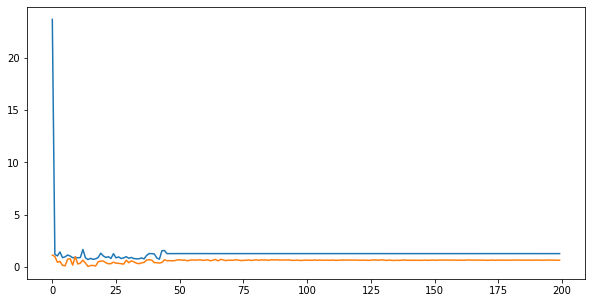

In [152]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(range(len(hist.history['loss'])), hist.history['loss'])
plt.plot(range(len(hist.history['val_loss'])), hist.history['val_loss'])
plt.show()

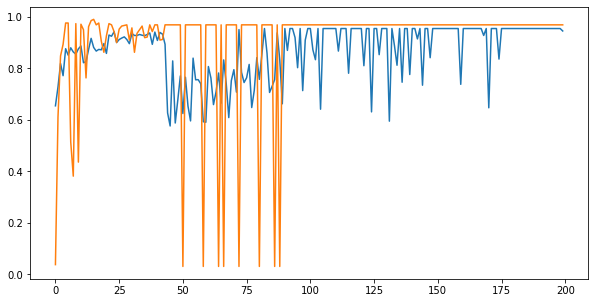

In [153]:
plt.figure(figsize=(10,5))
plt.plot(range(len(hist.history['acc'])), hist.history['acc'])
plt.plot(range(len(hist.history['val_acc'])), hist.history['val_acc'])
plt.show()

In [154]:
model.predict(val_ds.take(2))

2022-08-04 07:55:41.624419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.51942974],
       [0.519

In [155]:
[elem for elem in val_ds.take(1)]

[(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
  array([[[[2.16383850e+02, 2.04383850e+02, 1.90383850e+02],
           [2.20017944e+02, 2.08017944e+02, 1.94017944e+02],
           [2.19000000e+02, 2.07000000e+02, 1.93000000e+02],
           ...,
           [2.05964111e+02, 1.93964111e+02, 1.79964111e+02],
           [2.04000000e+02, 1.92000000e+02, 1.78000000e+02],
           [2.03053574e+02, 1.91053574e+02, 1.77053574e+02]],
  
          [[1.55191895e+02, 1.43191895e+02, 1.29191895e+02],
           [2.19292191e+02, 2.07292191e+02, 1.93292191e+02],
           [2.21000000e+02, 2.09000000e+02, 1.95000000e+02],
           ...,
           [2.02473206e+02, 1.91473206e+02, 1.73473206e+02],
           [2.00816772e+02, 1.89816772e+02, 1.71816772e+02],
           [1.99526779e+02, 1.88526779e+02, 1.70526779e+02]],
  
          [[2.20727600e+02, 2.08727600e+02, 1.94727600e+02],
           [2.12603470e+02, 2.00603470e+02, 1.86603470e+02],
           [2.21000000e+02, 2.09000000e+02, 1